# GPU Accelerated dataset analysis, visualization and outlier detection

Dataset analysis is a crucial part of data curation. One of the fundamental aspects of this analysis is to be able to visualize high dimensional data in low dimensions (<=3). We can identify patterns in our data, and also identify ouliers. This better enables us to identify how we want to proceed: Exclude the outliers or modify training strategies to account for them or root cause a failure mode in a simulation.

This tutorial walks one through how we can do this data analysis for CFD designs using Nvidia RAPIDS. 

## UMAP

Uniform Manifold Approximation and Projection (UMAP) is a popular technique that finds a low dimensional embedding of the data that approximates an underlying manifold.
Nvidia RAPIDS provides a [GPU accelerated implementation](https://docs.rapids.ai/api/cuml/stable/api/#umap).
The original paper can be found [here](https://arxiv.org/abs/1802.03426).

In order to perform dataset analysis on our DoMINO training ready dataset, we will leverage UMAP.
The specific use-case we're targeting is outlier detection. To highlight this, we're going to be mixing in two datasets: DrivAerML, and AhmedML. Both of these are supported by Curator.

The steps involved are:

1. Run ETL on the DrivAerML and AhmedML datasets using Curator. Instructions can be found [here](./README.md).
2. UMAP requires a high dimensional vector per data point that contains meaningful features. For this simple example, we'll compute a statistical feature vector per STL geometry in both datasets.
3. Run GPU accelerated UMAP on the stacked features (across both datasets) to compute the 2D embeddings.
4. Plot the final embeddings and analyze the results.

### Compute the feature descriptor

We'll compute a statistical feature descriptor per geometry.
The simple snippet of code below performs this task.

In [77]:
import cupy as cp
import numpy as np


def compute_feature_descriptor(
        areas_zarr,
        # x_bound, y_bound, z_bound,
        coords_zarr,
        centers_zarr
    ):
    """
    Compute a statistical feature descriptor vector using CuPy.
    
    Parameters:
        areas_zarr: Zarr array of triangle areas
        x_bound, y_bound, z_bound: [min, max] bounds for each axis
        coords_zarr: Zarr array of shape (N, 3) with all surface point coordinates
        centers_zarr: Zarr array of shape (M, 3) with triangle center coordinates
    
    Returns:
        descriptor (np.ndarray): shape (10,)
    """

    # # 1–3: Bounding box dimensions
    # x_extent = x_bound[1] - x_bound[0]
    # y_extent = y_bound[1] - y_bound[0]
    # z_extent = z_bound[1] - z_bound[0]

    # 4–5: Surface area stats
    areas_cp = cp.asarray(areas_zarr)
    surface_area_sum = float(cp.sum(areas_cp).get())
    surface_area_std = float(cp.std(areas_cp).get())

    # 6–7: Triangle center spread
    centers_cp = cp.asarray(centers_zarr)
    mesh_centroid = cp.mean(centers_cp, axis=0)
    dists = cp.linalg.norm(centers_cp - mesh_centroid, axis=1)
    centroid_dist_mean = float(cp.mean(dists).get())
    centroid_dist_std = float(cp.std(dists).get())

    # # 8–10: PCA eigenvalues of point cloud
    # coords_cp = cp.asarray(coords_zarr)
    # centered = coords_cp - cp.mean(coords_cp, axis=0)
    # cov = cp.cov(centered.T)
    # eigvals = cp.linalg.eigvalsh(cov)  # Already sorted ascending
    # eigvals = cp.flip(eigvals)  # Flip to descending
    # eigvals_norm = eigvals / cp.sum(eigvals)

    # pca_eigvals = eigvals_norm.get()  # Convert to NumPy

    # # Number of points
    # num_points = len(coords_zarr)

    # Final descriptor vector
    descriptor = np.array([
        # x_extent, y_extent, z_extent,
        surface_area_sum, surface_area_std,
        centroid_dist_mean, centroid_dist_std,
        # pca_eigvals[0], pca_eigvals[1], pca_eigvals[2],
        # num_points,
    ], dtype=np.float32)

    return descriptor

### UMAP embeddings

The below snippet is a thin wrapper around the RAPIDS implementation of UMAP.

In [78]:
from cuml.manifold import UMAP


def run_umap_gpu(descriptor_matrix_np, n_neighbors=20, min_dist=0.1):
    descriptors_cp = cp.asarray(descriptor_matrix_np.astype(np.float32))

    umap_model = UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42,
    )    
    embedding_cp = umap_model.fit_transform(descriptors_cp)

    embedding_np = cp.asnumpy(embedding_cp)
    return embedding_np

## Run the pipeline

The code below loads the data (STL keys), computes the feature vectors, computes the UMAP embeddings, and plots the results.

As we can see below, we can clearly see that the DrivAerML and AhmedML data points form different clusters. **Note how the DrivAerML data points are all on the positive x-axis, while the AhmedML data points are all on the negative x-axis.**

Successfully loaded 431 stores
Successfully loaded 500 stores
Computed descriptors for drivaerml
Computed descriptors for ahmedml
[2025-08-14 00:06:35.350] [CUML] [info] build_algo set to brute_force_knn because random_state is given


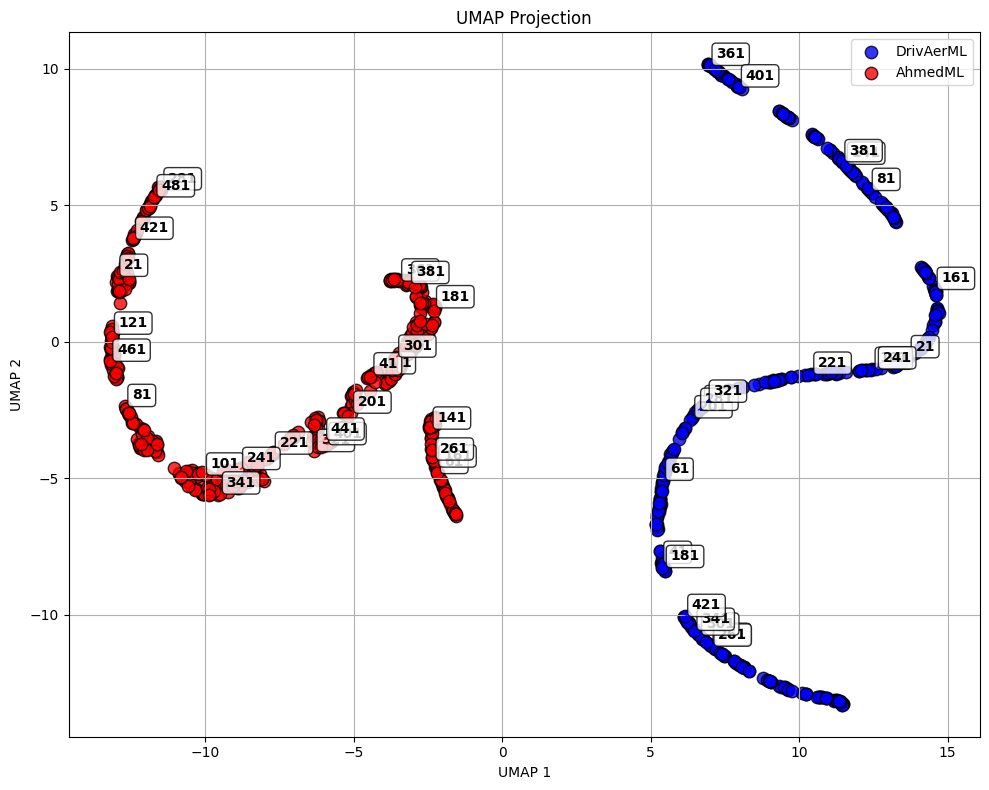

In [79]:
import os

import matplotlib.pyplot as plt
import zarr


def plot_umap_embeddings(embeddings_dict, title="UMAP Projection"):
    """
    Plot multiple UMAP embeddings on the same figure with different colors.
    
    Args:
        embeddings_dict: Dictionary with keys as dataset names and values as embeddings
        title: Title for the plot
    """
    plt.figure(figsize=(10, 8))
    
    # Define colors for different datasets
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for i, (dataset_name, embedding) in enumerate(embeddings_dict.items()):
        color = colors[i % len(colors)]
        
        # Plot the embedding points
        plt.scatter(embedding[:, 0], embedding[:, 1],
                    c=color, s=80, edgecolor='k', alpha=0.8, 
                    label=dataset_name)
        
        # Add text annotations every 20 points
        for j in range(0, len(embedding), 20):
            x, y = embedding[j]
            # Plotting j + 1 because the run directory names are 1-indexed
            plt.annotate(f'{j+1}', (x, y), 
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='black'),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color=color, alpha=0.7))

    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Load the data
def extract_key_data(zarr_path, required_keys):

    stores = [s for s in os.listdir(zarr_path) if s.endswith('.zarr')]
    stores = sorted(stores)

    data = {}
    for key in required_keys:
        data[key] = []
    data['valid_stores'] = []

    for store_name in stores:
        try:
            store_path = os.path.join(zarr_path, store_name)
            store = zarr.open(store_path, mode='r')
            
            # Check if all required keys are accessible before appending anything
            required_keys = ['stl_areas', 'stl_coordinates', 'stl_centers']
            all_keys_valid = True
            
            for key in required_keys:
                if key not in store:
                    print(f"Missing key '{key}' in store: {store_name}")
                    all_keys_valid = False
                    break
            
            # Only append data if all keys are valid
            if all_keys_valid:
                for key in required_keys:
                    data[key].append(store[key])
                data['valid_stores'].append(store_name)
            else:
                print(f"Skipping store {store_name} due to missing keys")
                
        except Exception as e:
            print("Error in store_name: ", store_name)
            print(e)

    print(f"Successfully loaded {len(data['valid_stores'])} stores")
    return data

drivaerml_zarr_path = '/mnt/nvme0n1/datasets/physicsnemo_dev/domino/stl_data_zarr_full/train'
ahmedml_zarr_path = '/mnt/nvme0n1/datasets/physicsnemo_dev/domino/ahmedml_stl_zarr'

drivaerml_extracted_data = extract_key_data(drivaerml_zarr_path, ['stl_areas', 'stl_coordinates', 'stl_centers'])
ahmedml_extracted_data = extract_key_data(ahmedml_zarr_path, ['stl_areas', 'stl_coordinates', 'stl_centers'])

drivaerml_descriptors = []
ahmedml_descriptors = []

for i in range(len(drivaerml_extracted_data['valid_stores'])):
    descriptor = compute_feature_descriptor(
        drivaerml_extracted_data['stl_areas'][i],
        drivaerml_extracted_data['stl_coordinates'][i],
        drivaerml_extracted_data['stl_centers'][i]
    )
    drivaerml_descriptors.append(descriptor)

drivaerml_descriptors = cp.asarray(drivaerml_descriptors)
print("Computed descriptors for drivaerml")

for i in range(len(ahmedml_extracted_data['valid_stores'])):
    descriptor = compute_feature_descriptor(
        ahmedml_extracted_data['stl_areas'][i],
        ahmedml_extracted_data['stl_coordinates'][i],
        ahmedml_extracted_data['stl_centers'][i]
    )
    ahmedml_descriptors.append(descriptor)

ahmedml_descriptors = cp.asarray(ahmedml_descriptors)
print("Computed descriptors for ahmedml")

# Stack both datasets together for UMAP
combined_descriptors = np.vstack([drivaerml_descriptors, ahmedml_descriptors])
combined_embedding = run_umap_gpu(combined_descriptors)

# Split the combined embedding back into separate arrays for plotting
drivaerml_count = drivaerml_descriptors.shape[0]
drivaerml_embedding_np = combined_embedding[:drivaerml_count]
ahmedml_embedding_np = combined_embedding[drivaerml_count:]


# Usage:
embeddings = {
    'DrivAerML': drivaerml_embedding_np,
    'AhmedML': ahmedml_embedding_np
}

plot_umap_embeddings(embeddings)